# Calculate all volumes of a regular grid, multiply by factor

Runtime comparison for a simple problem: Three arrays `dx`, `dy` and `dz` define the widths of the voxels in x-/y-/z-direction of a regular 3D grid. There are many possibilities to calculate each voxels' volume and multiply it by a factor, for instance

- Plain python (for comparison);
- Multiplication with broadcasting;
- `np.dot` twice, with broadcasting;
- `np.tensordot` twice;
- `np.meshgrid` and multiplication;
- `np.einsum`;
- Numexpr;
- Numba;
- Cython.

And sure enough there will be many more possibilities.

### Question: What is your approach in these situations?
Which way do you usually choose?
- The simplest?
- The fastest at any cost?
- The easiest to understand?
- The easiest to maintain?
- ...?

**Note:** Before running the notebook I set:
```
export MKL_NUM_THREADS=1
export OMP_NUM_THREADS=1
```
in the terminal, to ensure that all methods only use one processor in order for a fair comparison. Some of the methods would be able to use multiple threads, for instance `numexpr` or `np.dot`.

In [1]:
import numba
import cython
import numexpr
import numpy as np
import matplotlib.pyplot as plt

%load_ext cython
%matplotlib inline
%load_ext memory_profiler

plt.style.use('seaborn-notebook')

## Define the functions

In [2]:
def multiply_volume_plain(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    out = np.empty((len(dx), len(dy), len(dz)))
    for i, vx in enumerate(dx):
        tdx = x*vx
        for j, vy in enumerate(dy):
            tdxy = tdx*vy
            for k, vz in enumerate(dz):
                out[i, j, k] = tdxy*vz
    return out


def multiply_volume_broadcasting(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return x * dx[:, None, None] * dy[None, :, None] * dz[None, None, :]


def multiply_volume_dot(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return np.dot(np.dot(x*dx[:, None], dy[None, :])[:, :, None], dz[None, :])


def multiply_volume_tensordot(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return np.tensordot(np.tensordot(x*dx, dy, 0), dz, 0)


def multiply_volume_meshgrid(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    DX, DY, DZ = np.meshgrid(dx, dy, dz, indexing='ij')
    return x*DX*DY*DZ


def multiply_volume_einsum(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    return np.einsum('i,j,k->ijk', x*dx, dy, dz)


def multiply_volume_numexpr(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    bdx = dx[:, None, None]
    bdy = dy[None, :, None]
    bdz = dz[None, None, :]
    return numexpr.evaluate("x * bdx * bdy * bdz")


@numba.njit
def multiply_volume_numba(x, dx, dy, dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    nx = len(dx)
    ny = len(dy)
    nz = len(dz)
    out = np.empty((nx, ny, nz))
    for i in range(nx):
        tdx = x*dx[i]
        for j in range(ny):
            tdxy = tdx*dy[j]
            for k in range(nz):
                out[i, j, k] = tdxy*dz[k]
    return out

In [3]:
%%cython
cimport cython
import numpy as np
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
def multiply_volume_cython(np.float64_t x,
                           np.ndarray[np.float64_t, ndim=1] dx,
                           np.ndarray[np.float64_t, ndim=1] dy,
                           np.ndarray[np.float64_t, ndim=1] dz):
    """Multiply all voxels `dx x dy x dz` with a constant value x."""
    
    # Py_ssize_t is the proper C type for Python array indices.
    cdef Py_ssize_t nx = dx.shape[0]
    cdef Py_ssize_t ny = dy.shape[0]
    cdef Py_ssize_t nz = dz.shape[0]
    cdef Py_ssize_t i, j, k
    cdef np.float64_t tdx, tdxy
    
    # Create output array and a memory view of it
    out = np.empty((nx, ny, nz), dtype=np.float64)
    cdef np.float64_t[:, :, ::1] out_view = out
    
    # Calculation
    for i in range(nx):
        tdx = x*dx[i]
        for j in range(ny):
            tdxy = tdx*dy[j]
            for k in range(nz):
                out_view[i, j, k] = tdxy*dz[k]
    return out

## Collect functions

In [4]:
data = {
    'plain': {'func': multiply_volume_plain},
    'broadcasting': {'func': multiply_volume_broadcasting},
    'np.dot': {'func': multiply_volume_dot},
    'np.tensordot': {'func': multiply_volume_tensordot},
    'np.meshgrid': {'func': multiply_volume_meshgrid},
    'np.einsum': {'func': multiply_volume_einsum},
    'numexpr': {'func': multiply_volume_numexpr},
    'numba.jit': {'func': multiply_volume_numba},
    'cython': {'func': multiply_volume_cython}
}

## Define some input values

In [5]:
dx = np.random.rand(100)
dy = np.random.rand(100)
dz = np.random.rand(100)
x = 3.14

## Ensure results are the same

In [6]:
for key, item in data.items():
    data[key]['out'] = item['func'](x, dx, dy, dz)

same = []
for key, item in data.items():
    same.append(np.allclose(data['broadcasting']['out'], item['out']))

print('All results are numerically the same: ', np.all(same))

All results are numerically the same:  True


## Runtime comparison

In [7]:
for key, item in data.items():
    print('{:<12} :: '.format(key), end='')
    %timeit item['func'](x, dx, dy, dz)

plain        :: 299 ms ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
broadcasting :: 1.88 ms ± 35.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
np.dot       :: 8.97 ms ± 327 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
np.tensordot :: 1.65 ms ± 11.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
np.meshgrid  :: 18.2 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
np.einsum    :: 3.65 ms ± 97.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numexpr      :: 4.42 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
numba.jit    :: 883 µs ± 73.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
cython       :: 948 µs ± 51.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Memory comparison

In [8]:
for key, item in data.items():
    print('{:<12} :: '.format(key), end='')
    %memit item['func'](x, dx, dy, dz)

plain        :: peak memory: 206.44 MiB, increment: 0.41 MiB
broadcasting :: peak memory: 206.45 MiB, increment: 0.00 MiB
np.dot       :: peak memory: 206.45 MiB, increment: 0.00 MiB
np.tensordot :: peak memory: 206.45 MiB, increment: 0.00 MiB
np.meshgrid  :: peak memory: 229.27 MiB, increment: 22.82 MiB
np.einsum    :: peak memory: 206.45 MiB, increment: 7.50 MiB
numexpr      :: peak memory: 206.45 MiB, increment: 0.00 MiB
numba.jit    :: peak memory: 206.45 MiB, increment: 0.00 MiB
cython       :: peak memory: 206.45 MiB, increment: 0.00 MiB


## Extended runtime comparison

In [9]:
# nx/ny/nz-values
nx = [1, 10, 10, 10, 100, 100, 100, 1000]
ny = [1, 1, 10, 10, 10, 100, 100, 100]
nz = [1, 1, 1, 10, 10, 10, 100, 100]
nxyz = np.array(nx)*np.array(ny)*np.array(nz)
x = 3.5

# Initiate list
for key, item in data.items():
    data[key]['time'] = []

for i in range(len(nx)):
    dx = np.random.rand(nx[i])
    dy = np.random.rand(ny[i])
    dz = np.random.rand(nz[i])
    n = nxyz[i]
    print(n, '; ', end='')
    for key, item in data.items():
        out = %timeit -o -q item['func'](x, dx, dy, dz)
        data[key]['time'].append(1000*out.best)

1 ; 10 ; 100 ; 1000 ; 10000 ; 100000 ; 1000000 ; 10000000 ; 

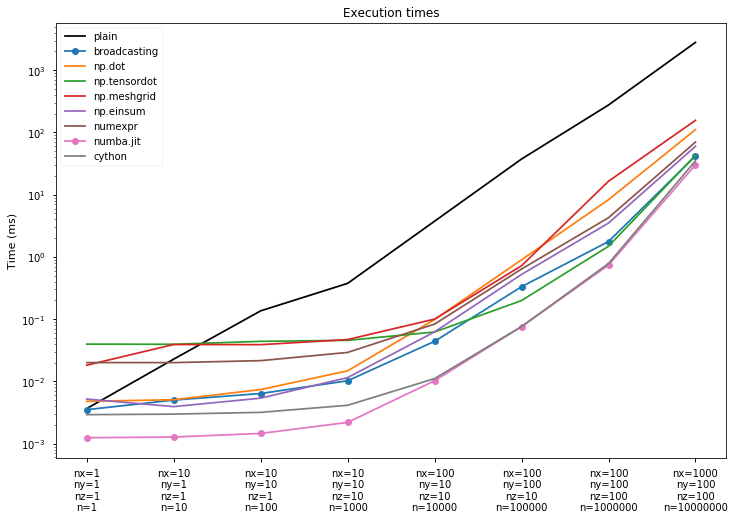

In [10]:
plt.figure(figsize=(12,8))

for key, item in data.items():
    if key in ['broadcasting', 'numba.jit']:
        ls = 'o-'
    elif key == 'plain':
        ls = 'k-'
    else:
        ls = '-'
    plt.plot(item['time'], ls, label=key)
plt.yscale('log')
plt.legend()
plt.title('Execution times')
plt.ylabel('Time (ms)')

label = []
for i in range(len(nx)):
    label.append('nx='+str(nx[i])+'\nny='+str(ny[i])+'\nnz='+str(nz[i])+'\nn='+str(nxyz[i])+'')
plt.xticks(np.arange(len(nx)), label)

plt.show()

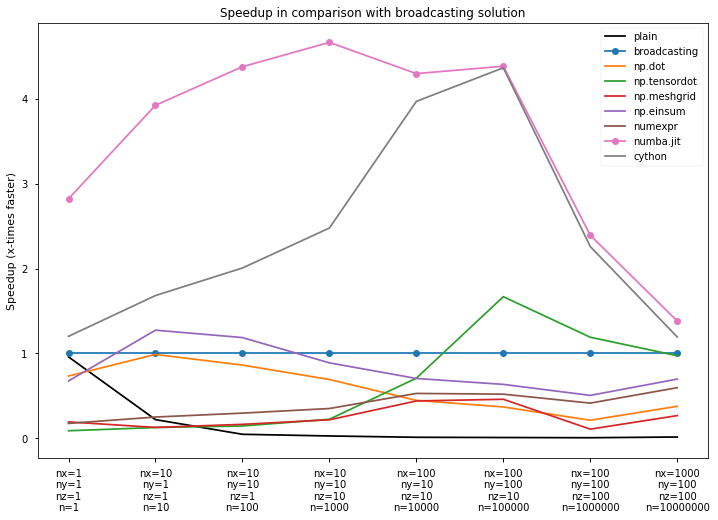

In [11]:
plt.figure(figsize=(12,8))

for key, item in data.items():
    if key in ['broadcasting', 'numba.jit']:
        ls = 'o-'
    elif key == 'plain':
        ls = 'k-'
    else:
        ls = '-'
    plt.plot(np.array(data['broadcasting']['time'])/np.array(item['time']), ls, label=key)
plt.legend()
plt.title('Speedup in comparison with broadcasting solution')
plt.ylabel('Speedup (x-times faster)')

label = []
for i in range(len(nx)):
    label.append('nx='+str(nx[i])+'\nny='+str(ny[i])+'\nnz='+str(nz[i])+'\nn='+str(nxyz[i])+'')
plt.xticks(np.arange(len(nx)), label)

plt.show()

My winners in this case are
- **Broadcasting** if it has to be simple, easy to understand and easy to maintain;
- **Numba** if it has to be as fast as possible.